In [1]:
# Cellule 1 : Imports et chargements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import joblib

# Charger les données
df = pd.read_csv("nhanes_ready.csv")

# Charger modèle + scaler du modèle 11
model = joblib.load("artifacts_diab_no_bias/model_lightgbm_diab_no_bias.pkl")
scaler = joblib.load("artifacts_diab_no_bias/scaler_diab_no_bias.pkl")

print("OK - modèle et données chargés.")


OK - modèle et données chargés.


In [2]:
# Cellule 2 — Recréation des features et du split identique au modèle 11

USE_ETHNICITY = True
target = "diabetes"

core = ["RIDAGEYR", "RIAGENDR", "smoker"]
morpho = ["BMXBMI_log", "BMXWAIST"]
lifestyle = ["PAD680_log", "SLD012"]

ethn = [
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
]

candidate_feats = core + morpho + lifestyle + ethn
features = [c for c in candidate_feats if c in df.columns]

X = df[features].copy()
y = df[target].astype(int)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

# Colonnes binaires non standardisées
binary_cols = ["RIAGENDR", "smoker"] + ethn
binary_cols = [c for c in binary_cols if c in X_train.columns]

num_cols = [c for c in X_train.columns if c not in binary_cols]

# Appliquer le scaler déjà entraîné
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("OK - X_test reconstruit.")


OK - X_test reconstruit.


In [4]:
# Cellule 4 — Identifier les faux négatifs
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

FN_mask = (y_test == 1) & (y_test_pred == 0)

df_FN = X_test.copy()
df_FN["y_true"] = y_test.values
df_FN["proba"] = y_test_proba
df_FN = df_FN[FN_mask]

print(f"Nombre de faux négatifs : {len(df_FN)} sur {len(X_test)}")
df_FN.head()


Nombre de faux négatifs : 28 sur 1378


,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,proba
4294,40.0,2,0,3.678829,119.5,5.198497,7.0,False,False,True,False,False,False,1,0.266889
888,80.0,2,0,3.238678,94.0,5.888878,7.0,False,False,True,False,False,False,1,0.262446
5498,60.0,2,0,3.254243,91.5,4.795791,8.0,False,False,False,False,True,False,1,0.411569
6709,67.0,2,0,3.202746,79.4,4.795791,8.0,False,False,False,False,True,False,1,0.215346
2,44.0,2,0,3.424263,93.5,5.484797,8.0,False,True,False,False,False,False,1,0.258714


In [5]:
# Cellule 5 — Profil statistique des FN
stats_FN = df_FN.describe().T[["mean", "std", "min", "max"]]
stats_all = X_test.describe().T[["mean", "std"]]

df_compare = pd.concat([stats_all, stats_FN], axis=1)
df_compare.columns = ["mean_all", "std_all", "mean_FN", "std_FN", "min_FN", "max_FN"]

df_compare


,mean_all,std_all,mean_FN,std_FN,min_FN,max_FN
RIDAGEYR,45.509434,22.266661,51.178571,16.503767,26.000000,80.000000
RIAGENDR,1.554427,0.497209,1.678571,0.475595,1.000000,2.000000
smoker,0.319303,0.466376,0.321429,0.475595,0.000000,1.000000
BMXBMI_log,3.341736,0.255694,3.406799,0.243448,3.010621,4.041295
BMXWAIST,95.411176,18.934874,100.307143,18.837609,79.400000,158.300000
PAD680_log,5.690655,0.693841,5.576514,0.667411,3.713572,6.734592
SLD012,7.783019,1.459231,7.714286,1.003960,6.000000,9.500000
y_true,NaN,NaN,1.000000,0.000000,1.000000,1.000000
proba,NaN,NaN,0.333199,0.118522,0.028419,0.493536


<Figure size 1000x600 with 0 Axes>

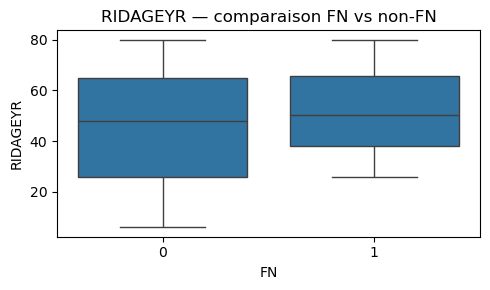

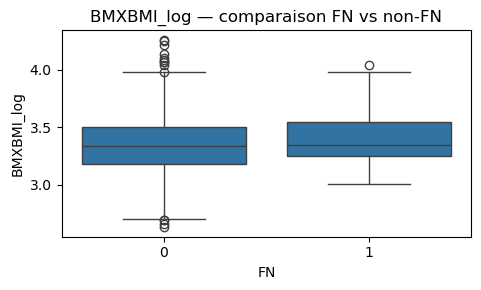

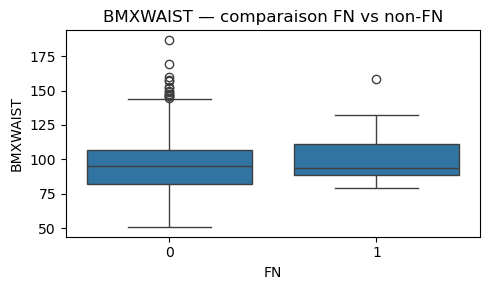

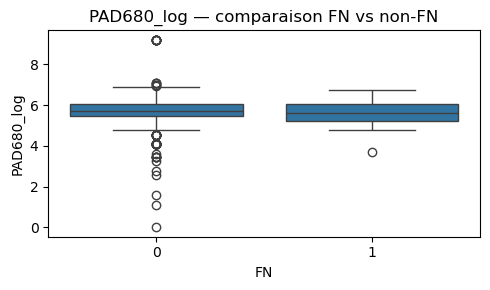

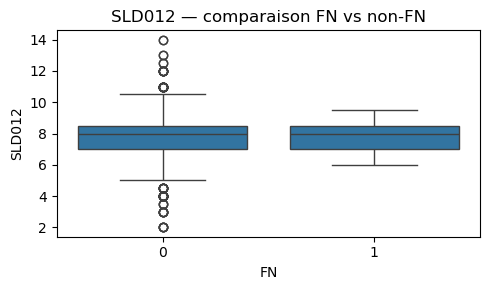

In [6]:
# Cellule 6 — Boxplots comparatifs
plt.figure(figsize=(10,6))
df_plot = X_test.copy()
df_plot["FN"] = FN_mask.astype(int)

for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(data=df_plot, x="FN", y=col)
    plt.title(f"{col} — comparaison FN vs non-FN")
    plt.tight_layout()
    plt.show()


In [7]:

# Sauvegarde rapide des splits
pd.DataFrame(X_test).to_csv("X_test_chol.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_chol.csv", index=False)

print("CSV test sauvegardés.")


CSV test sauvegardés.
